### Application of LSTM
* <b>`LSTM` to predict time series and sequential data.</b>
* We are using `LSTM` to predict timeseries data the price of stocks.

In [1]:
!pip install pandas numpy torch matplotlib yfinance --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import yfinance as yf
from datetime import datetime

### Loading data

In [3]:
end = datetime.now()
start = datetime(end.year - 20, end.month, end.day)
symbol = '^NSEI'
nifty_50_data = yf.download(symbol, start, end)

[*********************100%***********************]  1 of 1 completed


In [4]:
df = pd.DataFrame(nifty_50_data)
df.to_csv('nifty_50.csv')

# Exploration and Cleaning

In [5]:
df.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI
Date,,,,,,
2007-09-17 00:00:00+00:00,4494.649902,4494.649902,4549.049805,4482.850098,4518.450195,0
2007-09-18 00:00:00+00:00,4546.200195,4546.200195,4551.799805,4481.549805,4494.100098,0
2007-09-19 00:00:00+00:00,4732.350098,4732.350098,4739.000000,4550.250000,4550.250000,0
2007-09-20 00:00:00+00:00,4747.549805,4747.549805,4760.850098,4721.149902,4734.850098,0
2007-09-21 00:00:00+00:00,4837.549805,4837.549805,4855.700195,4733.700195,4752.950195,0


In [6]:
df.reset_index(inplace=True)
df.columns

MultiIndex([(     'Date',      ''),
            ('Adj Close', '^NSEI'),
            (    'Close', '^NSEI'),
            (     'High', '^NSEI'),
            (      'Low', '^NSEI'),
            (     'Open', '^NSEI'),
            (   'Volume', '^NSEI')],
           names=['Price', 'Ticker'])

In [7]:
df.columns = df.columns.droplevel(1)

In [8]:
data = df[['Date','Close']]
data.tail()

Price,Date,Close
4196,2024-10-30 00:00:00+00:00,24340.849609
4197,2024-10-31 00:00:00+00:00,24205.349609
4198,2024-11-01 00:00:00+00:00,24304.349609
4199,2024-11-04 00:00:00+00:00,23995.349609
4200,2024-11-05 00:00:00+00:00,24213.300781


<ipython-input-9-eef3cfff9d19>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


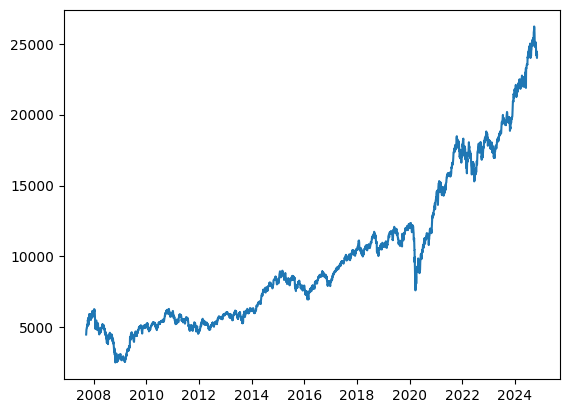

In [9]:
data['Date'] = pd.to_datetime(data['Date'])
plt.plot(data['Date'], data['Close'])

In [10]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

### Transforming dataset

In [11]:
from copy import deepcopy as dc

def lstm_df(self,window_size=15):
  df = dc(data)
  df.set_index('Date',inplace=True)

  for i in range(1,window_size+1):
    df['Close(t-{})'.format(i)] = df['Close'].shift(i)

  df.dropna(inplace=True)
  return df
data = lstm_df(data)
data.tail()

Price,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7),Close(t-8),Close(t-9),Close(t-10),Close(t-11),Close(t-12),Close(t-13),Close(t-14),Close(t-15)
Date,,,,,,,,,,,,,,,,
2024-10-30 00:00:00+00:00,24340.849609,24466.849609,24339.150391,24180.800781,24399.400391,24435.500000,24472.099609,24781.099609,24854.050781,24749.849609,24971.300781,25057.349609,25127.949219,24964.250000,24998.449219,24981.949219
2024-10-31 00:00:00+00:00,24205.349609,24340.849609,24466.849609,24339.150391,24180.800781,24399.400391,24435.500000,24472.099609,24781.099609,24854.050781,24749.849609,24971.300781,25057.349609,25127.949219,24964.250000,24998.449219
2024-11-01 00:00:00+00:00,24304.349609,24205.349609,24340.849609,24466.849609,24339.150391,24180.800781,24399.400391,24435.500000,24472.099609,24781.099609,24854.050781,24749.849609,24971.300781,25057.349609,25127.949219,24964.250000
2024-11-04 00:00:00+00:00,23995.349609,24304.349609,24205.349609,24340.849609,24466.849609,24339.150391,24180.800781,24399.400391,24435.500000,24472.099609,24781.099609,24854.050781,24749.849609,24971.300781,25057.349609,25127.949219
2024-11-05 00:00:00+00:00,24213.300781,23995.349609,24304.349609,24205.349609,24340.849609,24466.849609,24339.150391,24180.800781,24399.400391,24435.500000,24472.099609,24781.099609,24854.050781,24749.849609,24971.300781,25057.349609


In [12]:
data.head()

Price,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7),Close(t-8),Close(t-9),Close(t-10),Close(t-11),Close(t-12),Close(t-13),Close(t-14),Close(t-15)
Date,,,,,,,,,,,,,,,,
2007-10-09 00:00:00+00:00,5327.250000,5085.100098,5185.850098,5208.649902,5210.799805,5068.950195,5021.350098,5000.549805,4940.500000,4938.850098,4932.200195,4837.549805,4747.549805,4732.350098,4546.200195,4494.649902
2007-10-10 00:00:00+00:00,5441.450195,5327.250000,5085.100098,5185.850098,5208.649902,5210.799805,5068.950195,5021.350098,5000.549805,4940.500000,4938.850098,4932.200195,4837.549805,4747.549805,4732.350098,4546.200195
2007-10-11 00:00:00+00:00,5524.850098,5441.450195,5327.250000,5085.100098,5185.850098,5208.649902,5210.799805,5068.950195,5021.350098,5000.549805,4940.500000,4938.850098,4932.200195,4837.549805,4747.549805,4732.350098
2007-10-12 00:00:00+00:00,5428.250000,5524.850098,5441.450195,5327.250000,5085.100098,5185.850098,5208.649902,5210.799805,5068.950195,5021.350098,5000.549805,4940.500000,4938.850098,4932.200195,4837.549805,4747.549805
2007-10-15 00:00:00+00:00,5670.399902,5428.250000,5524.850098,5441.450195,5327.250000,5085.100098,5185.850098,5208.649902,5210.799805,5068.950195,5021.350098,5000.549805,4940.500000,4938.850098,4932.200195,4837.549805


In [13]:
data = data.to_numpy()
data

array([[ 5327.25      ,  5085.10009766,  5185.85009766, ...,
         4732.35009766,  4546.20019531,  4494.64990234],
       [ 5441.45019531,  5327.25      ,  5085.10009766, ...,
         4747.54980469,  4732.35009766,  4546.20019531],
       [ 5524.85009766,  5441.45019531,  5327.25      , ...,
         4837.54980469,  4747.54980469,  4732.35009766],
       ...,
       [24304.34960938, 24205.34960938, 24340.84960938, ...,
        25057.34960938, 25127.94921875, 24964.25      ],
       [23995.34960938, 24304.34960938, 24205.34960938, ...,
        24971.30078125, 25057.34960938, 25127.94921875],
       [24213.30078125, 23995.34960938, 24304.34960938, ...,
        24749.84960938, 24971.30078125, 25057.34960938]])

### Scaling the data between 0 and 1

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(data)
data

array([[0.11831284, 0.10809203, 0.11234454, ..., 0.09320294, 0.08534581,
        0.08316995],
       [0.12313307, 0.11831284, 0.10809203, ..., 0.0938445 , 0.09320294,
        0.08534581],
       [0.12665326, 0.12313307, 0.11831284, ..., 0.09764327, 0.0938445 ,
        0.09320294],
       ...,
       [0.91930976, 0.91513111, 0.92085037, ..., 0.95109284, 0.95407275,
        0.94716323],
       [0.9062673 , 0.91930976, 0.91513111, ..., 0.94746084, 0.95109284,
        0.95407275],
       [0.91546671, 0.9062673 , 0.91930976, ..., 0.93811369, 0.94746084,
        0.95109284]])

### Flipping dataset as it makes traing model easier

In [15]:
X = data[:,1:]
X = dc(np.flip(X,axis=1))
y = data[:,0]
X.shape, y.shape

((4186, 15), (4186,))

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15,shuffle=False)

### Preparing for model training in batches

In [17]:
lookback = 15
X_train = X_train.reshape((-1,lookback,1))
X_test = X_test.reshape((-1,lookback,1))

y_test = y_test.reshape((-1,1))
y_train = y_train.reshape((-1,1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3558, 15, 1), (628, 15, 1), (3558, 1), (628, 1))

In [18]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
  def __init__(self,X,y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self,index):
    return self.X[index], self.y[index]

train_dataset = TimeSeriesDataset(X_train,y_train)
test_dataset = TimeSeriesDataset(X_test,y_test)

In [19]:
batch_size = 32
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [20]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([32, 15, 1]) torch.Size([32, 1])


# Model &  Model training

In [21]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [22]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].type(torch.float32).to(device), batch[1].type(torch.float32).to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}'.format(batch_index+1))
            running_loss = 0.0
    print()

In [23]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].type(torch.float32).to(device), batch[1].type(torch.float32).to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.4f}'.format(avg_loss_across_batches))
    print('***************************************************')

In [32]:
learning_rate = 0.001
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100

Val Loss: 0.0002
***************************************************
Epoch: 2
Batch 100

Val Loss: 0.0003
***************************************************
Epoch: 3
Batch 100

Val Loss: 0.0002
***************************************************
Epoch: 4
Batch 100

Val Loss: 0.0002
***************************************************
Epoch: 5
Batch 100

Val Loss: 0.0002
***************************************************
Epoch: 6
Batch 100

Val Loss: 0.0002
***************************************************
Epoch: 7
Batch 100

Val Loss: 0.0002
***************************************************
Epoch: 8
Batch 100

Val Loss: 0.0002
***************************************************
Epoch: 9
Batch 100

Val Loss: 0.0002
***************************************************
Epoch: 10
Batch 100

Val Loss: 0.0002
***************************************************
Epoch: 11
Batch 100

Val Loss: 0.0002
***************************************************
Epoch: 12
Batch 100

In [33]:
with torch.no_grad():
    # Convert X_train to a PyTorch tensor before moving it to the device
    predicted = model(torch.tensor(X_train, dtype=torch.float32).to(device)).to('cpu').numpy()

In [34]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 5061.00254425,  5299.75484908,  5411.84521923, ...,
       17147.16372176, 16922.29526717, 17033.09211309])

In [35]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])

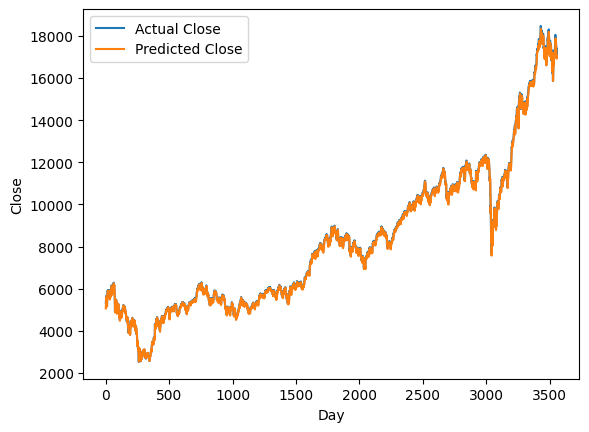

In [36]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [37]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test[0:100]

array([17171.94921875, 16953.94921875, 17200.80078125, 17038.40039062,
       17245.05078125, 17102.55078125, 17069.09960938, 16677.59960938,
       16682.65039062, 16411.25      , 16301.84960938, 16240.04980469,
       16167.09960938, 15808.        , 15782.15039062, 15842.29980469,
       16259.29980469, 16240.29980469, 15809.40039062, 16266.15039062,
       16214.70019531, 16125.15039062, 16025.79980469, 16170.15039062,
       16352.45019531, 16661.40039062, 16584.55078125, 16522.75      ,
       16628.        , 16584.30078125, 16569.55078125, 16416.34960938,
       16356.25      , 16478.09960938, 16201.79980469, 15774.40039062,
       15732.09960938, 15692.15039062, 15360.59960938, 15293.5       ,
       15350.15039062, 15638.79980469, 15413.29980469, 15556.65039062,
       15699.25      , 15832.04980469, 15850.20019531, 15799.09960938,
       15780.25      , 15752.04980469, 15835.34960938, 15810.84960937,
       15989.79980469, 16132.90039062, 16220.59960938, 16216.        ,
      

In [38]:
test_predictions = model(torch.tensor(X_test, dtype=torch.float32).to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions[0:100]

array([17268.33982868, 17131.8250098 , 16920.34933225, 17086.52200682,
       16989.64749207, 17136.28456167, 17050.37111139, 17002.55307931,
       16671.6128138 , 16616.18191152, 16387.22388688, 16256.47061697,
       16188.00562231, 16118.06352466, 15801.97478131, 15731.19810635,
       15778.76195244, 16142.34252252, 16184.81558822, 15816.84607349,
       16145.33061997, 16162.27352791, 16081.56241743, 15983.74741454,
       16091.82447044, 16265.36571425, 16550.672535  , 16532.38385348,
       16470.44437788, 16547.60253317, 16525.58014199, 16507.47927568,
       16376.38850326, 16303.42724099, 16396.63159256, 16181.39819888,
       15778.1335482 , 15682.54973339, 15642.04378478, 15351.05167086,
       15251.37122529, 15292.63973185, 15550.59755292, 15393.51767584,
       15489.67340911, 15629.85274258, 15762.58442673, 15795.80935906,
       15754.16804639, 15730.33669829, 15702.83942345, 15770.38228785,
       15760.44361589, 15910.46277121, 16056.09863046, 16150.69676851,
      

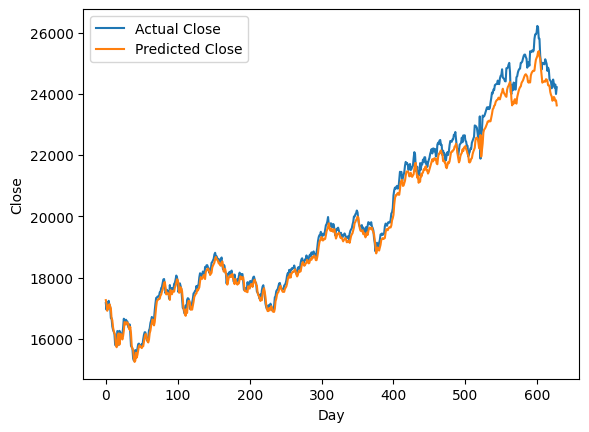

In [39]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
model.eval()
preds = []
actuals = []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(torch.device("cpu"))
        logits = model(X)
        prob = torch.softmax(logits, dim=1)
        pred = torch.argmax(prob, dim=1)
        preds.extend(pred.cpu().numpy())
        actuals.extend(y.numpy())

preds = np.array(preds)
actuals = np.array(actuals)

acc = accuracy_score(actuals, preds)
prec = precision_score(actuals, preds)
recall = recall_score(actuals, preds)
f1 = f1_score(actuals, preds)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", confusion_matrix(actuals, preds))

## Inference
### The model is clearly overfit and will forcast a biased estimate of the index